# NGC 346 stars from Hubble Source Catalog

This is based off the notebook example at https://archive.stsci.edu/hst/hsc/help/api/hscv3_smc_api.html

But I have taken the HSC API routines and put them in a file.  I had to do a `conda install requests`. 

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.table import Table

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

sys.path.append("../lib")
import hubble_source_catalog as hsc

Set up the target:

In [2]:
target = 'NGC 346'
ra, dec = hsc.resolve(target)
print(target, ra, dec)

NGC 346 14.77101 -72.1771


And do the actual search:

In [4]:
import time

In [42]:
columns = """MatchID,MatchRA,MatchDec,CI,A_F555W,A_F814W""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

# select objects with at least one ACS F555W and ACS F814W measurement
# and with concentration index 0.9 < CI < 1.6, consistent with point sources
# search a small 3x3 arcmin box in RA and Dec centered on the SMC
ddec = 3.0 / 60.0
dra = ddec / np.cos(np.radians(dec))
constraints = {'A_F555W_N.gte': 1, 'A_F814W_N.gte': 1, 'CI.gt':0.5, 'CI.lt':1.6,
               'MatchDec.gt': dec - ddec, 'MatchDec.lt': dec + ddec,
               'MatchRA.gt': ra - dra, 'MatchRA.lt': ra + dra}

# do a search with a large number of rows allowed
t0 = time.time()
tab = ascii.read(
    hsc.hscsearch(
        table="summary",
        release='v3',
        columns=columns,
        verbose=True,
        pagesize=2000000,
        **constraints
    )
)
print("{:.1f} s: retrieved data and converted to {}-row astropy table".format(time.time()-t0, len(tab)))

# compute color column and select for objects in more limited color range
tab['V-I'] = tab['A_F555W'] - tab['A_F814W']
tab = tab[(tab['V-I'] < 2.5) & (tab['V-I'] > -2.5)]
print("{:.1f} s: selected {} objects with -2.5 < V-I < 2.5".format(time.time()-t0, len(tab)))

# clean up the output format
tab['A_F555W'].format = "{:.3f}"
tab['A_F814W'].format = "{:.3f}"
tab['V-I'].format = "{:.3f}"
tab['CI'].format = "{:.3f}"
tab['MatchRA'].format = "{:.6f}"
tab['MatchDec'].format = "{:.6f}"

tab

https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/summary/magaper2.csv?pagesize=2000000&A_F555W_N.gte=1&A_F814W_N.gte=1&CI.gt=0.5&CI.lt=1.6&MatchDec.gt=-72.2271&MatchDec.lt=-72.1271&MatchRA.gt=14.607651787990683&MatchRA.lt=14.934368212009318&columns=%5BMatchID%2CMatchRA%2CMatchDec%2CCI%2CA_F555W%2CA_F814W%5D
9.4 s: retrieved data and converted to 78519-row astropy table
9.4 s: selected 78484 objects with -2.5 < V-I < 2.5


<Table length=78484>
MatchID   MatchRA   MatchDec     CI   A_F555W A_F814W   V-I  
 int64    float64   float64   float64 float64 float64 float64
-------- --------- ---------- ------- ------- ------- -------
89313853 14.748782 -72.176445   1.513  23.498  22.819   0.679
89434485 14.720860 -72.170557   1.008  23.101  23.024   0.077
89621660 14.743106 -72.175433   1.159  25.755  24.874   0.882
89635992 14.687640 -72.164645   1.071  26.352  25.548   0.804
43922497 14.787630 -72.173211   0.985  21.181  21.594  -0.413
43966573 14.734093 -72.174360   1.117  25.172  24.499   0.673
44158748 14.771428 -72.166749   0.984  21.487  21.776  -0.289
44235913 14.741682 -72.173816   1.180  22.241  21.702   0.539
44376347 14.783961 -72.169773   1.013  23.570  23.427   0.143
44474532 14.745306 -72.174027   0.945  23.258  23.126   0.132
     ...       ...        ...     ...     ...     ...     ...
96230168 14.768875 -72.213243   1.003  21.653  21.916  -0.263
96256444 14.765559 -72.212652   1.113  25.509  24.949   0.560
96357983 14.764317 -72.212292   1.014  21.963  22.155  -0.192
96844547 14.778655 -72.215279   1.111  26.376  25.526   0.851
96846989 14.797681 -72.214813   1.062  21.069  21.477  -0.407
96884186 14.791859 -72.214219   1.171  25.128  24.647   0.480
96982172 14.793595 -72.213796   1.087  24.682  24.410   0.272
97014553 14.788935 -72.214267   1.066  25.764  25.111   0.653
97200847 14.795784 -72.214022   1.144  24.049  22.820   1.229
97264812 14.792758 -72.211590   1.054  24.257  23.858   0.398

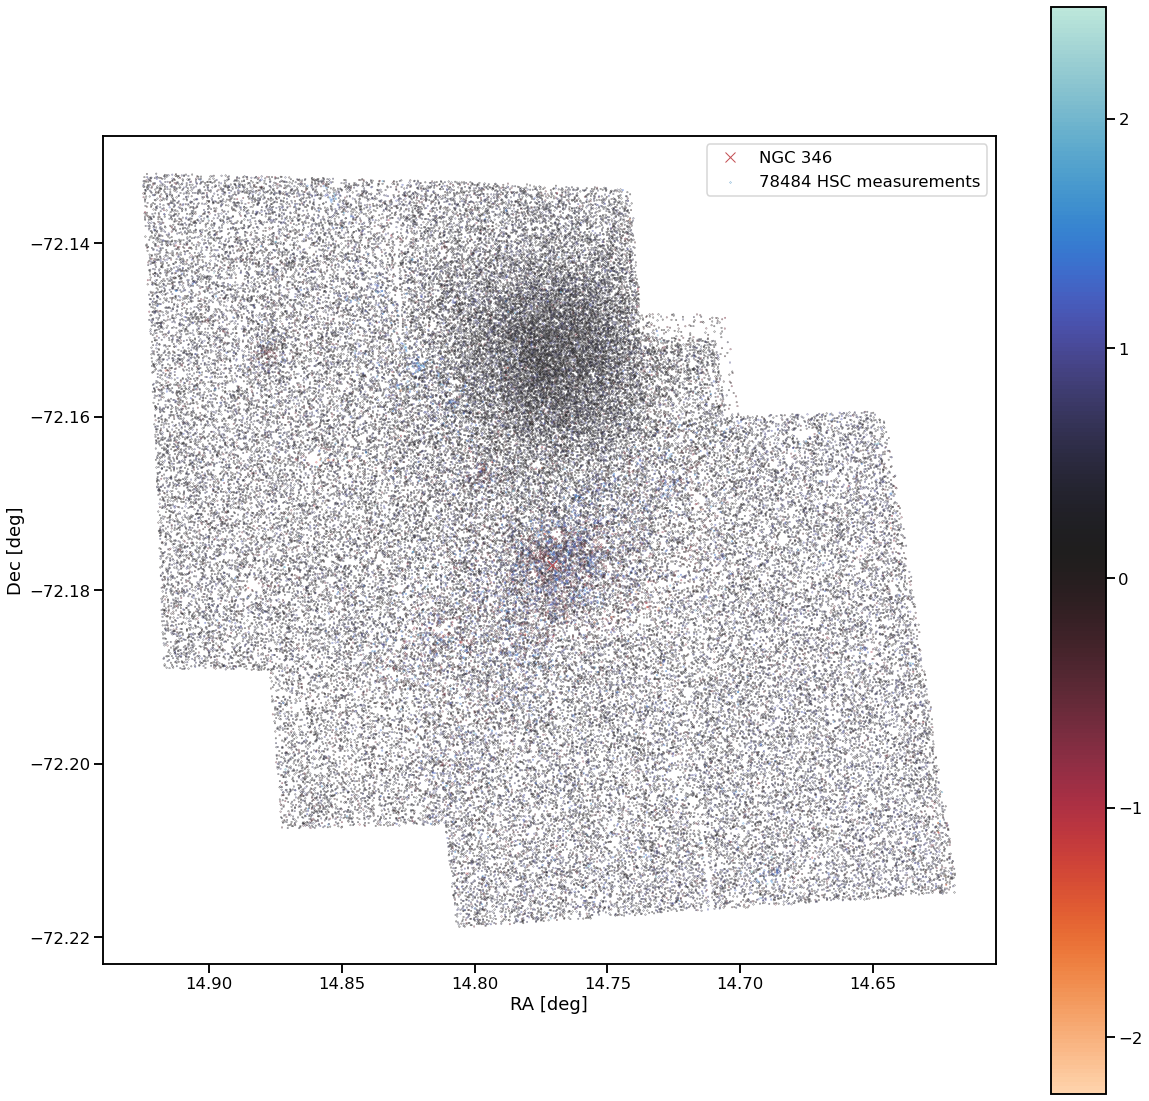

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))

stars = ax.scatter(
    tab['MatchRA'], 
    tab['MatchDec'], 
    s=0.1,
    c=tab["V-I"].data,
    cmap="icefire_r",
    alpha=1.0,
    label=f'{len(tab)} HSC measurements'
)
ax.plot(ra, dec, 'rx', label=target, markersize=10)
fig.colorbar(stars, ax=ax)
ax.invert_xaxis()
ax.set_aspect(1.0/np.cos(np.radians(dec)))
ax.set(
    xlabel='RA [deg]',
    ylabel='Dec [deg]',
)
ax.legend()

Zoom in on cluster

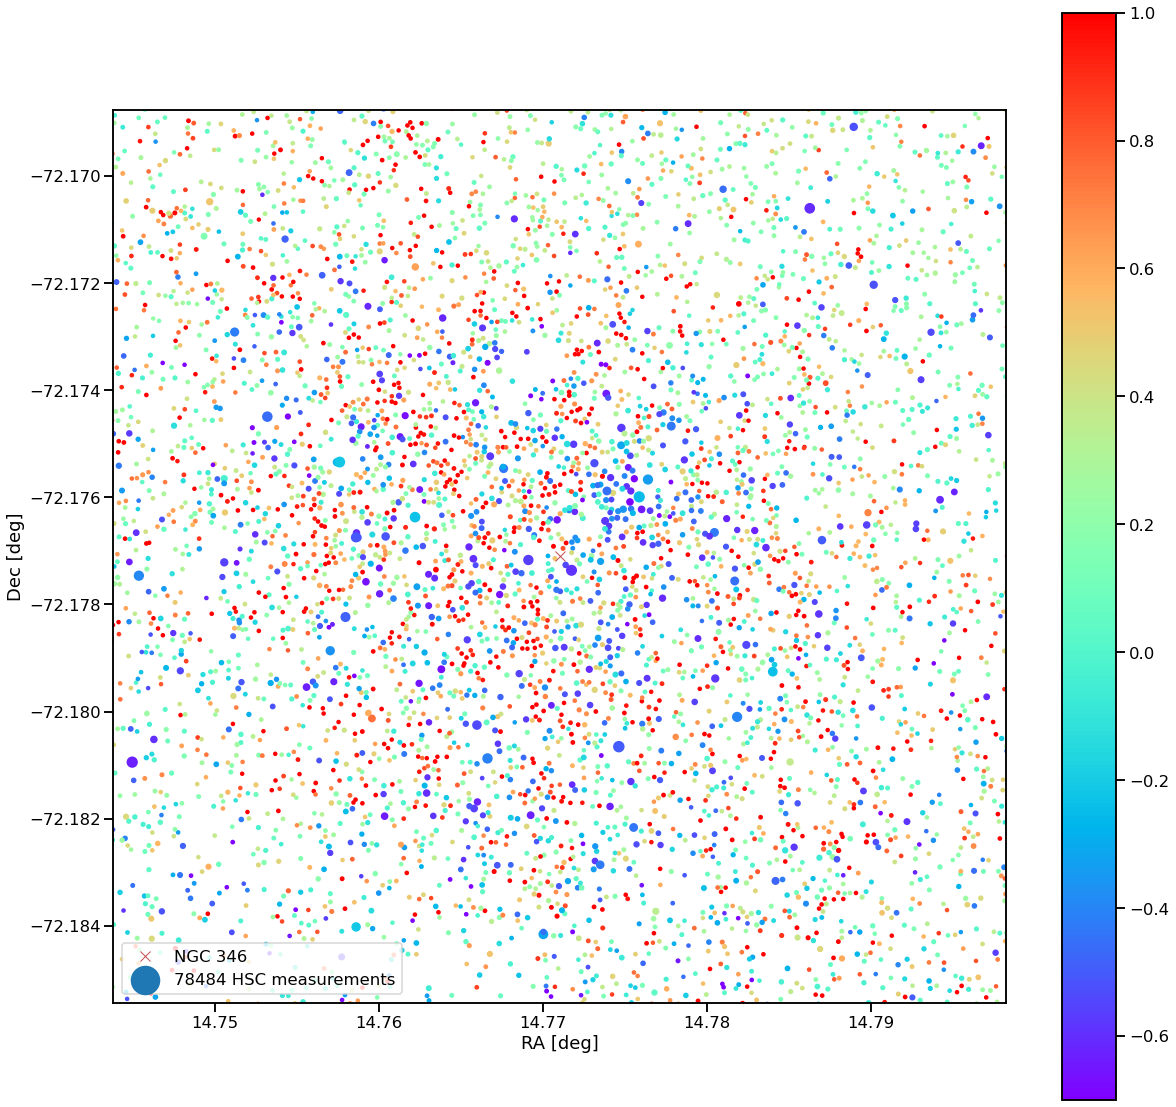

In [45]:
fig, ax = plt.subplots(figsize=(20, 20))

stars = ax.scatter(
    tab['MatchRA'], 
    tab['MatchDec'], 
    s=100.0/(tab["A_F555W"] - 15.1),
    c=tab["V-I"].data,
    vmin=-0.7,
    vmax=1.0,
    cmap="rainbow",
    alpha=1.0,
    label=f'{len(tab)} HSC measurements'
)
ax.plot(ra, dec, 'rx', label=target, markersize=10)
fig.colorbar(stars, ax=ax)
ax.invert_xaxis()
ax.set_aspect(1.0/np.cos(np.radians(dec)))
dec_range = 0.5/60.0
ra_range = dec_range / np.cos(np.radians(dec))
ax.set(
    xlim=[ra - ra_range, ra + ra_range],
    ylim=[dec - dec_range, dec + dec_range],
    xlabel='RA [deg]',
    ylabel='Dec [deg]',
)
ax.legend()

I am using hue to represent the $V - I$ color and symbol size to represent the $V$ magnitude.

## Combine with Hα map

In [46]:
bigdatapath = Path("../big-data")

In [48]:
hdu = fits.open(bigdatapath / "ngc346-hst-acs-f658n-wcsgaia.fits")["SCI"]
w = WCS(hdu.header)
imha = hdu.data

<ipython-input-57-f919b97bf573>:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(imha),
<ipython-input-57-f919b97bf573>:4: RuntimeWarning: invalid value encountered in log10
  np.log10(imha),


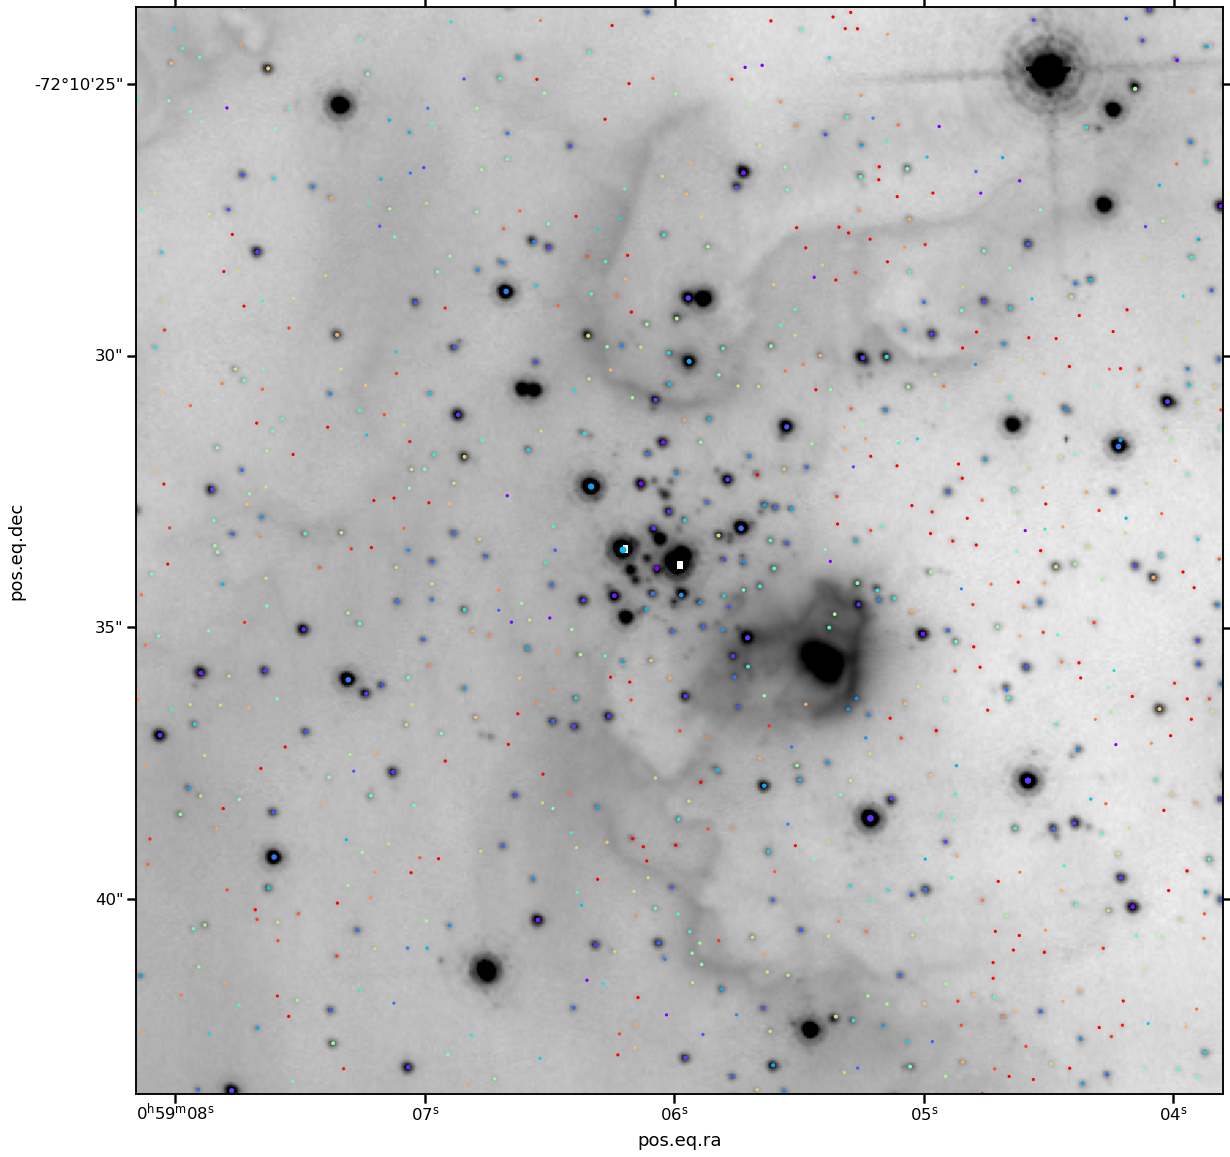

In [57]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=w)
ax.imshow(
    np.log10(imha), 
    vmin=-0.7, vmax=0.7, 
    cmap="gray_r",
)
stars = ax.scatter(
    tab['MatchRA'], 
    tab['MatchDec'], 
    s=30.0/(tab["A_F555W"] - 15.1),
    c=np.array(tab["V-I"].data),
    #edgecolors="w",
    vmin=-0.7,
    vmax=1.0,
    cmap="rainbow",
    facecolor="none",
    alpha=1.0,
    transform=ax.get_transform('world'),    
)
ax.set(
    xlim=[2400, 2800],
    ylim=[2000, 2400],
);

## Add the Gaia sources too

In [58]:
datapath = Path("../data")
dfgaia = pd.read_csv(datapath / "1621565655827O-result.csv")

<ipython-input-61-ec9d95a33bc8>:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(imha),
<ipython-input-61-ec9d95a33bc8>:4: RuntimeWarning: invalid value encountered in log10
  np.log10(imha),
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


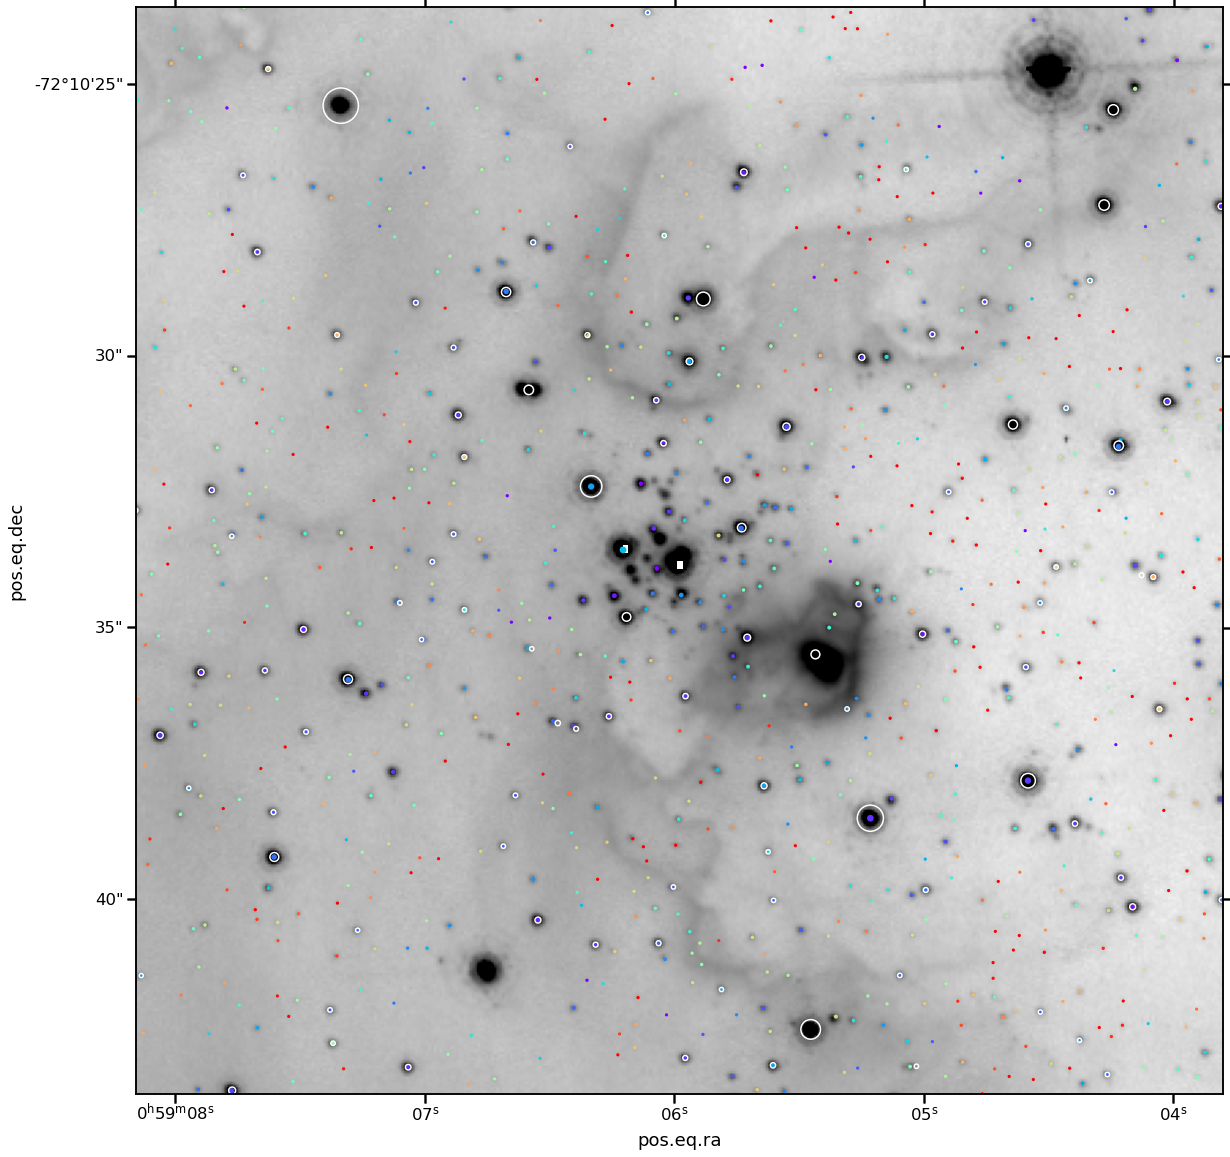

In [61]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=w)
ax.imshow(
    np.log10(imha), 
    vmin=-0.7, vmax=0.7, 
    cmap="gray_r",
)
stars = ax.scatter(
    tab['MatchRA'], 
    tab['MatchDec'], 
    s=30.0/(tab["A_F555W"] - 15.1),
    c=np.array(tab["V-I"].data),
    #edgecolors="w",
    vmin=-0.7,
    vmax=1.0,
    cmap="rainbow",
    facecolor="none",
    alpha=1.0,
    transform=ax.get_transform('world'),    
)
gstars = ax.scatter(
    x="ra", y="dec", 
    edgecolors="w", 
    data=dfgaia,
    s=100/(dfgaia["phot_g_mean_mag"] - 15), 
    alpha=1.0,
    facecolor="none",
    transform=ax.get_transform('world'),
)
ax.set(
    xlim=[2400, 2800],
    ylim=[2000, 2400],
);

So we can see that neither catalog is complete.

What about the bespoke studies, like Nota+ (2006) and Sabbi+ (2007)?

- [ ] ***Yes, there is a Vizier table for Sabbi, which I should get***